Reading cleaned games files into dataframe

In [7]:
from os import listdir
from os.path import isfile, join
import os

In [8]:
cleanedGamesFolderName = "SplitIndividualGamesCleaned"
gamesCleanedFileNames = [f for f in listdir(cleanedGamesFolderName) if isfile(join(cleanedGamesFolderName, f))]    
    #game_df = pd.read_csv(fullGameFileName,skiprows=2,header=None)
    #game_df = pd.read_fwf(fullGameFileName,skiprows=1,header=None)
#print(gamesCleanedFileNames)

In [11]:
import pandas as pd
import numpy as np
import re

In [31]:
all_games = pd.DataFrame(columns = ["PlayerADoubles", "PlayerBDoubles", "IsAWinner"])
rowN = 0; # row index to write to dataframe
#indFLcount = 0
for fileName in gamesCleanedFileNames:
    indFL = "Y" # indicator whether the game is valid (cleaned properly)
    fullCleanedGameFileName = cleanedGamesFolderName + "/" + fileName
    PlayerADoubles = 0; # number of doubles in a game for Player A
    PlayerBDoubles = 0; # number of doubles in a game for Player B
    column_names = ["MoveN","PlayerA_Roll","PlayerA_Move","PlayerB_Roll","PlayerB_Move"];
    game_df = pd.read_csv(fullCleanedGameFileName,delimiter=',', names=column_names, dtype=str)
    game_df = game_df.astype(str)
    for i in range(0,len(game_df)):
        RollA = game_df.PlayerA_Roll[i]
        if re.search(r"[1-6][1-6]",RollA):
            if RollA[0] == RollA[1]:
                PlayerADoubles = PlayerADoubles + 1
        RollB = game_df.PlayerB_Roll[i]
        if re.search(r"[1-6][1-6]",RollB):
            if RollB[0] == RollB[1]:
                PlayerBDoubles = PlayerBDoubles + 1
        if i == len(game_df)-1:
            if re.search("Wins",game_df.PlayerA_Move[i]):
                IsAWinner = "Y"
            elif re.search("Wins",game_df.PlayerB_Move[i]):
                IsAWinner = "N"
            else:
                indFL = "N"
                #indFLcount = indFLcount + 1
                #print(fileName)
                #print("ERROR: NO WINNER FOUND")
    if indFL == "Y":
        all_games.loc[rowN] = [PlayerADoubles] + [PlayerBDoubles] + [IsAWinner]
        rowN = rowN + 1
#print(indFLcount)    

In [32]:
all_games["PlayerAMoreDoubles"] = all_games["PlayerADoubles"] - all_games["PlayerBDoubles"]
all_games["PlayerAMoreDoubles"] = all_games["PlayerAMoreDoubles"].apply(lambda x: np.sign(x))

In [33]:
WinnerHadMoreDoubles = list()
for i in range(0,len(all_games)):
    IsAW = all_games.IsAWinner[i]
    PAMoreD = all_games.PlayerAMoreDoubles[i]
    if ((IsAW == "Y") & (PAMoreD == 1)) | ((IsAW == "N") & (PAMoreD == -1)):
        WinnerHadMoreDoubles.append("More")
    elif ((IsAW == "Y") & (PAMoreD == -1)) | ((IsAW == "N") & (PAMoreD == 1)):
        WinnerHadMoreDoubles.append("Less")
    elif PAMoreD == 0:
        WinnerHadMoreDoubles.append("Same")
    else:
        print("ERROR: Unhandled case")
all_games["WinnerHadMoreDoubles"] = WinnerHadMoreDoubles

In [34]:
print(len(all_games))
all_games.head(20)

11278


,PlayerADoubles,PlayerBDoubles,IsAWinner,PlayerAMoreDoubles,WinnerHadMoreDoubles
0,11,3,N,1,Less
1,1,0,Y,1,More
2,2,0,N,1,Less
3,7,6,Y,1,More
4,1,1,Y,0,Same
5,6,4,Y,1,More
6,2,5,N,-1,More
7,5,2,Y,1,More
8,5,4,N,1,Less
9,6,9,Y,-1,Less


In [66]:
counts = all_games["WinnerHadMoreDoubles"].value_counts().to_dict()
print(counts)
counts_ratio = [counts["More"]/len(all_games)*100,counts["Less"]/len(all_games)*100,counts["Same"]/len(all_games)*100]
counts_ratio_dict = {"More": counts_ratio[0],"Less": counts_ratio[1],"Same": counts_ratio[2]}
print(counts_ratio_dict)

{'More': 5287, 'Less': 3675, 'Same': 2316}
{'More': 46.87887923390672, 'Less': 32.58556481645682, 'Same': 20.53555594963646}


Create a pie chart based on stats above

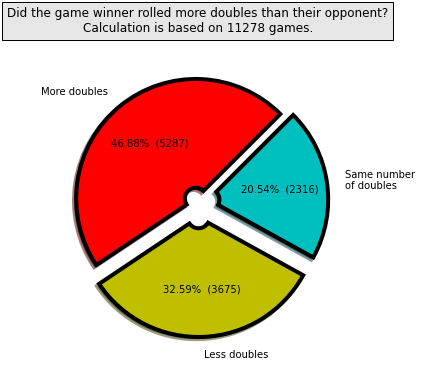

In [204]:
import matplotlib.pyplot as plt

# Data to plot
labels = []
values = []
colors = ['r','y','c'] # Color of each section
explode = [0.03,0.15,0.1] # To slice the perticuler section
labels = ["More doubles","Less doubles","Same number \nof doubles"]

for x, y in counts.items():
    values.append(y)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize = (3,2))
wedgeprops = {"linewidth": 4, 'width':1, "edgecolor":"k"} # Width = 1
plt.pie(
        values, 
        labels = labels, 
        explode = explode, 
        colors = colors, 
        autopct = make_autopct(values), 
        pctdistance = 0.6, 
        shadow =True, 
        labeldistance = 1.15, 
        startangle = 45,
        radius = 1.1, 
        counterclock = True, 
        wedgeprops = wedgeprops,
        center=(0.5, -0.5),
        frame=True,
        )
#ax = axes([0.1, 0.1, 0.8, 0.8])
plt.axis("off")
plt.title("Did the game winner rolled more doubles than their opponent?\nCalculation is based on " + str(len(all_games)) + " games." ,bbox={'facecolor': '0.9', 'pad': 5})
#plt.show()
plt.savefig('Findings/doubles-study1.png',bbox_inches='tight')